<a href="https://colab.research.google.com/github/shumshersubashgautam/Multimodal-Classification/blob/main/Multimodal_Learning_BERT_BERT_ResNet_and_ALBEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
#

In [2]:
cd multimodal

/content/multimodal


In [3]:
!bash prepare_folders_and_download_files.sh

Creating data folder and downloading data files
--2023-06-30 02:46:46--  https://drive.google.com/uc?id=1r4aTTbLuYgGrgpZLOgUH9sQ33DBsbOFm&export=download
Resolving drive.google.com (drive.google.com)... 172.217.194.101, 172.217.194.138, 172.217.194.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.194.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/03b2c69sn7m37rk3lqdoknu9ncm7nt2a/1688093175000/05977284540357373744/*/1r4aTTbLuYgGrgpZLOgUH9sQ33DBsbOFm?e=download&uuid=38ff8016-f820-42dd-a005-fdad342b428a [following]
--2023-06-30 02:46:52--  https://doc-10-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/03b2c69sn7m37rk3lqdoknu9ncm7nt2a/1688093175000/05977284540357373744/*/1r4aTTbLuYgGrgpZLOgUH9sQ33DBsbOFm?e=download&uuid=38ff8016-f820-42dd-a005-fdad342b428a
Resolving doc-10-9c-docs.googleusercontent.com (doc-10-9c-

In [6]:
# !pip install -r requirements.txt

In [7]:
# install required libraries
!pip install transformers timm

In [8]:
import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd

In [9]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# set random seeds for repeatability
import numpy as np
import random

def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [11]:
seed_val = 0
set_seed(seed_val)

In [15]:
# HOME_FOLDER = '/content/drive/MyDrive/KDD/' # if mounted
HOME_FOLDER = '/content/multimodal/KDD/' # if not mounted
WEBVISION_DATA_FOLDER = HOME_FOLDER + 'webvision_data/'
IMAGE_FOLDER = WEBVISION_DATA_FOLDER + 'images/'
RESULTS_FOLDER = HOME_FOLDER + 'results/'
TRAINED_MODELS_FOLDER = HOME_FOLDER + 'trained_models/'
os.makedirs(RESULTS_FOLDER, exist_ok=True)

In [13]:
# !mkdir -p $WEBVISION_DATA_FOLDER
# !wget "https://drive.google.com/uc?id=1r4aTTbLuYgGrgpZLOgUH9sQ33DBsbOFm&export=download" -O $WEBVISION_DATA_FOLDER/data.zip
# !unzip $WEBVISION_DATA_FOLDER/data.zip -d $WEBVISION_DATA_FOLDER

In [16]:
df_train = pd.read_csv(WEBVISION_DATA_FOLDER + 'train.csv')
df_test = pd.read_csv(WEBVISION_DATA_FOLDER + 'test.csv')

In [17]:
import matplotlib.pyplot as plt

def show_sample(row_num):
    sample_row = df_train.iloc[row_num]
    print('Index:', row_num)
    print('Label:', sample_row['label'])
    print('Text:', sample_row['text'])
    image_path = IMAGE_FOLDER + sample_row['img_path']
    im = Image.open(image_path)
    plt.imshow(im)

Index: 394
Label: bookshop
Text: The highest forms of literature were to be found on the English bookstall. Perhaps these should be in the Self-Help section .


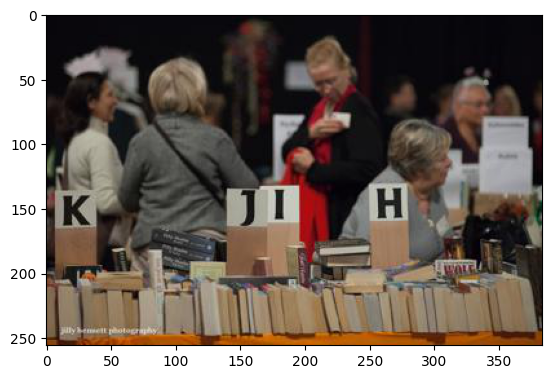

In [18]:
from random import randint
show_sample(randint(0, len(df_train)))

In [19]:
label_to_id = {lab:i for i, lab in enumerate(df_train['label'].sort_values().unique())}
id_to_label = {v:k for k,v in label_to_id.items()}

In [20]:
label_to_id

{'bookshop': 0,
 'breakwater': 1,
 'chiton': 2,
 'coil': 3,
 'confectionery': 4,
 'gar': 5,
 'gasmask': 6,
 'polecat': 7,
 'seashore': 8,
 'streetcar': 9}

In [21]:
num_out_labels = len(label_to_id)

In [22]:
## training parameters to be used for all models ##
num_train_epochs = 5
batch_size = 16
learning_rate = 1.0e-5
weight_decay = 0.01
warmup_steps = 0
max_seq_length = 64

**BERT**

The first model which we are going to train is a BERT model which only uses the text from the data.

**Dataset**

Since we are training a text only model, the dataset which we fit into the model only requires two attributes: text and label.

In [23]:
class TextDataset(Dataset):
    def __init__(self, df, label_to_id, text_field="text", label_field="label"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.text_field = text_field
        self.label_field = label_field

    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]

        return text, label

    def __len__(self):
        return self.df.shape[0]

**Model**

The model uses BERT to encode the text, and feeds the encodings (a 768 dimension vector) into a fully connected linear layer with 10 outputs (one for each class label).

In [24]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [25]:
class VLBertModel(nn.Module):

    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()

        self.num_labels = num_labels
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size, num_labels)


    def forward(self, text):
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask, return_dict=True)
        logits = self.classifier(output.last_hidden_state[:, 0, :]) # CLS embedding
        return logits

In [26]:
# create the model
bert_model = VLBertModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
bert_model = bert_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# **Training**

In [27]:
set_seed(seed_val)

train_dataset = TextDataset(df=df_train, label_to_id=label_to_id, text_field='text', label_field='label')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(bert_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

bert_model.train()


start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_text, b_labels = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )

        b_labels = b_labels.to(device)
        b_inputs = b_inputs.to(device)

        bert_model.zero_grad()
        b_logits = bert_model(text=b_inputs)

        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()

    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])

end = perf_counter()
bert_training_time = end- start
print('Training completed in ', bert_training_time, 'seconds')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 108.78022038936615
    avg_epoch_loss = 2.175604407787323
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 76.00956296920776
    avg_epoch_loss = 1.5201912593841553
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 50.48365435004234
    avg_epoch_loss = 1.0096730870008468
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 41.30632698535919
    avg_epoch_loss = 0.8261265397071839
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 38.86054664850235
    avg_epoch_loss = 0.777210932970047
    learning rate = 0.0
Training completed in  40.006916198 seconds


# **Testing**

In [28]:
bert_prediction_results = []

test_dataset = TextDataset(df=df_test, label_to_id=label_to_id, text_field='text', label_field='label')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  bert_model.eval()

  b_text, b_labels = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = bert_model(text=b_inputs)
      b_logits = b_logits.detach().cpu()

  bert_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

bert_prediction_labels = [id_to_label[p] for p in bert_prediction_results]

  0%|          | 0/13 [00:00<?, ?it/s]

In [29]:
bert_class_report = classification_report(df_test['label'], bert_prediction_labels, output_dict=True)
bert_class_report['training_time (seconds)'] = bert_training_time

with open(RESULTS_FOLDER + 'bert_class_report.json', 'w') as f:
  json.dump(bert_class_report, f)

print(bert_class_report['accuracy'])

0.82


**BERT + ResNet-50**

The next model that we are training uses a combination of BERT and ResNet-50 to encode the text and images, respectively.

**Dataset**

Unlike the previous Dataset used for BERT, we include images in this dataset by reading the image files and applying a series of transformations to them so that they can fit into the ResNet model.

In [30]:
class ResNetDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field

        # ResNet-50 settings
        self.img_size = 224
        self.mean, self.std = (
            0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)


        self.train_transform_func = transforms.Compose(
                [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

        self.eval_transform_func = transforms.Compose(
                [transforms.Resize(256),
                    transforms.CenterCrop(self.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])


    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]


        image = Image.open(img_path)
        if self.train:
          img = self.train_transform_func(image)
        else:
          img = self.eval_transform_func(image)

        return text, label, img

    def __len__(self):
        return self.df.shape[0]

**Model**

The original ResNet model consists of a fully connected layer with 1000 classes at the end, to show the scores of each image belonging to that class. However, our output classes are different and we want to use the image features before the fully connected layer instead of the 1000-class output probabilities. Therefore, we "extract" this model out of the original ResNet model architecture by leaving out the fully connected layer.

After that, we pair the extracted ResNet model with a BERT model and add a 10-class linear layer on top of them, like we did for the previous BERT classifier.

The ResNet-50 model is trained on imagenet data to classify images into 1000 classes, therefore the last layer is a fully connected layer with 1000 output nodes. This output is not useful to us since our output classes are different. Therefore, we need to strip off this fully connected layer and use the features after the last average pooling layer. This can be done by copying the layers and weights to another network and leave out the last layer.

In [31]:
# extract layers of resnet-50 to build a new model

import torch.nn as nn
from torchvision.models.resnet import resnet50

class ResNetFeatureModel(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        pretrained_resnet = resnet50(pretrained=True)
        self.children_list = []
        for n,c in pretrained_resnet.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)


    def forward(self,x):
        x = self.net(x)
        x = torch.flatten(x, 1)
        return x

In [32]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [33]:
# last output layer name for resnet is named 'layer4', dim 2048*7*7
# last layer name before fc is named 'avgpool', dim 2048*1*1 -> needs to be flattened
# reference: https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-c00589bda32b

class BertResNetModel(nn.Module):
    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.visual_encoder = ResNetFeatureModel(output_layer='avgpool')
        self.image_hidden_size = 2048

        self.classifier = nn.Linear(self.text_encoder.config.hidden_size + self.image_hidden_size, num_labels)

    def forward(self, text, image):
        text_output = self.text_encoder(**text)
        text_feature = text_output.last_hidden_state[:, 0, :]
        img_feature = self.visual_encoder(image)
        features = torch.cat((text_feature, img_feature), 1)

        logits = self.classifier(features)

        return logits

In [34]:
resnet_model = BertResNetModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
resnet_model = resnet_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weig

**Training**

Similar to BERT training, but we take in images as an additional input

In [35]:
## training loop
set_seed(seed_val)

train_dataset = ResNetDataset(df=df_train, label_to_id=label_to_id, train=True, text_field='text', label_field='label', image_path_field='img_path')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

resnet_model.train()

start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_text, b_labels, b_imgs = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )

        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        resnet_model.zero_grad()
        b_logits = resnet_model(text=b_inputs, image=b_imgs)

        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()

    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])
end = perf_counter()
resnet_training_time = end- start
print('Training completed in ', resnet_training_time, 'seconds')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 106.55971658229828
    avg_epoch_loss = 2.1311943316459656
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 76.40244245529175
    avg_epoch_loss = 1.528048849105835
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 54.98492211103439
    avg_epoch_loss = 1.099698442220688
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 45.47947996854782
    avg_epoch_loss = 0.9095895993709564
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 42.85773968696594
    avg_epoch_loss = 0.8571547937393188
    learning rate = 0.0
Training completed in  91.74319882399993 seconds


# **Testing**

In [36]:
# testing loop

resnet_prediction_results = []

test_dataset = ResNetDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  resnet_model.eval()

  b_text, b_labels, b_imgs = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_imgs = b_imgs.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = resnet_model(text=b_inputs, image=b_imgs)
      b_logits = b_logits.detach().cpu()

  resnet_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

resnet_prediction_labels = [id_to_label[p] for p in resnet_prediction_results]

  0%|          | 0/13 [00:00<?, ?it/s]

In [37]:
resnet_class_report = classification_report(df_test['label'], resnet_prediction_labels, output_dict=True)
resnet_class_report['training_time (seconds)'] = resnet_training_time

with open(RESULTS_FOLDER + 'resnet_class_report.json', 'w') as f:
  json.dump(resnet_class_report, f)

print(resnet_class_report['accuracy'])

0.795


**ALBEF**

In [38]:
ALBEF_FOLDER = HOME_FOLDER + 'ALBEF/'
os.makedirs(ALBEF_FOLDER, exist_ok=True)

In [39]:
# download pre-trained ALBEF model and required ALBEF files from ALBEF's official repo (only need to do this once to save it in your gdrive)
!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/vit.py -O $ALBEF_FOLDER/vit.py
!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/tokenization_bert.py -O $ALBEF_FOLDER/tokenization_bert.py
!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/xbert.py -O $ALBEF_FOLDER/xbert.py

--2023-06-30 03:01:12--  https://raw.githubusercontent.com/salesforce/ALBEF/main/models/vit.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8558 (8.4K) [text/plain]
Saving to: ‘/content/multimodal/KDD/ALBEF//vit.py’

/content/multimodal 100%[===================>]   8.36K  --.-KB/s    in 0s      

2023-06-30 03:01:12 (67.3 MB/s) - ‘/content/multimodal/KDD/ALBEF//vit.py’ saved [8558/8558]

--2023-06-30 03:01:12--  https://raw.githubusercontent.com/salesforce/ALBEF/main/models/tokenization_bert.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

In [40]:
# replace all occurrences of tokenizer_class with processor_class in xbert.py to make it compatible with newer transformers version
# if you don't do this step, you will need to install transformers==4.8.1 as specified by the requirements in the ALBEF repo

!sed -i 's/tokenizer_class/processor_class/g' $ALBEF_FOLDER/xbert.py

In [41]:
# add path to downloaded ALBEF files
import sys
sys.path.append(ALBEF_FOLDER)

#import libraries required for ALBEF
from vit import VisionTransformer
from xbert import BertConfig as AlbefBertConfig, BertModel as AlbefBertModel
from functools import partial

**Dataset**

Same as the BERT-ResNet Dataset which contains text, images and labels. The only difference here is the image size (ResNet - 224, ALBEF - 256).

In [42]:
class AlbefDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field

        # ALBEF settings
        self.img_size = 256
        self.mean, self.std = (
            0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)


        self.train_transform_func = transforms.Compose(
                [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

        self.eval_transform_func = transforms.Compose(
                [transforms.Resize(256),
                    transforms.CenterCrop(self.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])


    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]


        image = Image.open(img_path)
        if self.train:
          img = self.train_transform_func(image)
        else:
          img = self.eval_transform_func(image)

        return text, label, img

    def __len__(self):
        return self.df.shape[0]

**Model**

ALBEF also uses BERT as its text encoder. Its image encoder is actually a VisionTransformer model. We use the joint text-image encoder to encode both the text and images, and as with the previous two models, add a linear fully connected layer to it.

In [43]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [44]:
class AlbefModel(nn.Module):

    def __init__(self, bert_config, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()

        self.num_labels = num_labels
        self.text_encoder = AlbefBertModel.from_pretrained(
            text_pretrained, config=bert_config, add_pooling_layer=False)

        self.visual_encoder = VisionTransformer(
            img_size=256, patch_size=16, embed_dim=768, depth=12, num_heads=12,
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size, num_labels)


    def forward(self, text, image):
        image_embeds = self.visual_encoder(image)
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(image_embeds.device)
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask,
                                   encoder_hidden_states=image_embeds, encoder_attention_mask=image_atts, return_dict=True
                                   )
        logits = self.classifier(output.last_hidden_state[:, 0, :])
        return logits

Because ALBEF aligns the BERT and VisionTransformers features, it has its own BERT configuration. We download both this configuration and the pretrained model from Salesforce's GitHub and web pages in the function below which loads a pretrained model.

In [45]:
from urllib.request import urlretrieve

def load_albef_pretrained(num_out_labels):
    tmp_directory = './tmp/albef'
    os.makedirs(tmp_directory, exist_ok=True)

    albef_bert_config_fp = os.path.join(tmp_directory, 'config_bert.json')
    albef_model_fp = os.path.join(tmp_directory, 'ALBEF.pth')

    if not os.path.exists(albef_bert_config_fp):
        urlretrieve("https://raw.githubusercontent.com/salesforce/ALBEF/main/configs/config_bert.json", albef_bert_config_fp)

    if not os.path.exists(albef_model_fp):
        urlretrieve("https://storage.googleapis.com/sfr-pcl-data-research/ALBEF/ALBEF_4M.pth", albef_model_fp)

    albef_bert_config = AlbefBertConfig.from_json_file(albef_bert_config_fp)
    albef_model = AlbefModel(bert_config=albef_bert_config, num_labels=num_out_labels)

    albef_checkpoint = torch.load(albef_model_fp, map_location='cpu')
    albef_state_dict = albef_checkpoint['model']

    for key in list(albef_state_dict.keys()):
        if 'bert' in key:
            encoder_key = key.replace('bert.', '')
            albef_state_dict[encoder_key] = albef_state_dict[key]
            del albef_state_dict[key]

    msg = albef_model.load_state_dict(albef_state_dict, strict=False)
    print("ALBEF checkpoint loaded from ", albef_model_fp)
    print(msg)
    return albef_model

In [46]:
albef_model = load_albef_pretrained(num_out_labels=num_out_labels)
albef_model = albef_model.to(device)

ALBEF checkpoint loaded from  ./tmp/albef/ALBEF.pth
_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=['temp', 'image_queue', 'text_queue', 'queue_ptr', 'vision_proj.weight', 'vision_proj.bias', 'text_proj.weight', 'text_proj.bias', 'itm_head.weight', 'itm_head.bias', 'visual_encoder_m.cls_token', 'visual_encoder_m.pos_embed', 'visual_encoder_m.patch_embed.proj.weight', 'visual_encoder_m.patch_embed.proj.bias', 'visual_encoder_m.blocks.0.norm1.weight', 'visual_encoder_m.blocks.0.norm1.bias', 'visual_encoder_m.blocks.0.attn.qkv.weight', 'visual_encoder_m.blocks.0.attn.qkv.bias', 'visual_encoder_m.blocks.0.attn.proj.weight', 'visual_encoder_m.blocks.0.attn.proj.bias', 'visual_encoder_m.blocks.0.norm2.weight', 'visual_encoder_m.blocks.0.norm2.bias', 'visual_encoder_m.blocks.0.mlp.fc1.weight', 'visual_encoder_m.blocks.0.mlp.fc1.bias', 'visual_encoder_m.blocks.0.mlp.fc2.weight', 'visual_encoder_m.blocks.0.mlp.fc2.bias', 'visual_encoder_m.blocks.1.norm1

**Training**

In [47]:
## training loop
set_seed(seed_val)

train_dataset = AlbefDataset(df=df_train, label_to_id=label_to_id, train=True, text_field='text', label_field='label', image_path_field='img_path')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(albef_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

albef_model.train()

start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_text, b_labels, b_imgs = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )

        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        albef_model.zero_grad()
        b_logits = albef_model(text=b_inputs, image=b_imgs)

        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()

    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])
end = perf_counter()
albef_training_time = end- start
print('Training completed in ', albef_training_time, 'seconds')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 104.06949090957642
    avg_epoch_loss = 2.0813898181915285
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 69.81609058380127
    avg_epoch_loss = 1.3963218116760254
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 46.829983949661255
    avg_epoch_loss = 0.936599678993225
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 37.099952310323715
    avg_epoch_loss = 0.7419990462064743
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 34.59084126353264
    avg_epoch_loss = 0.6918168252706528
    learning rate = 0.0
Training completed in  235.13218671899995 seconds


**Testing**

In [48]:
# testing loop

albef_prediction_results = []

test_dataset = AlbefDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  albef_model.eval()

  b_text, b_labels, b_imgs = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_imgs = b_imgs.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = albef_model(text=b_inputs, image=b_imgs)
      b_logits = b_logits.detach().cpu()



  albef_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

albef_prediction_labels = [id_to_label[p] for p in albef_prediction_results]

  0%|          | 0/13 [00:00<?, ?it/s]

In [49]:
albef_class_report = classification_report(df_test['label'], albef_prediction_labels, output_dict=True)
albef_class_report['training_time (seconds)'] = albef_training_time

with open(RESULTS_FOLDER + 'albef_class_report.json', 'w') as f:
  json.dump(albef_class_report, f)

print(albef_class_report['accuracy'])

0.795


Predict on models trained with 20 epochs
In the previous segments, we trained each model for only 5 epochs due to the tutorial's time constraint. Thus, we cannot see a significant contrast between the accuracies of the models. Training for more epochs will improve the models' accuracies. Therefore, we have trained the models for 20 epochs each and saved them. In this segment, we will load the models and make predictions on the test set to compare their accuracies.

The code in the previous segments have to be reused to load the models. Before executing this step, the following cells must have been executed:

Setup and common config cells
ALBEF-specific cells
ALBEF-loading cells
Cells containing model code for BERT, BERT-ResNet and ALBEF

This function loads the pretrained model for each of the three model architectures.

In [50]:
# Download trained_models.zip file to trained_models folder
!wget "https://drive.google.com/u/0/uc?id=1MGaKK4nHTd4FWDnvFihb6b8lASjeuN_l&export=download&confirm=t" -O $HOME_FOLDER/trained_models.zip
!unzip $HOME_FOLDER/trained_models.zip -d $HOME_FOLDER

--2023-06-30 03:10:35--  https://drive.google.com/u/0/uc?id=1MGaKK4nHTd4FWDnvFihb6b8lASjeuN_l&export=download&confirm=t
Resolving drive.google.com (drive.google.com)... 172.217.194.102, 172.217.194.101, 172.217.194.139, ...
Connecting to drive.google.com (drive.google.com)|172.217.194.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1MGaKK4nHTd4FWDnvFihb6b8lASjeuN_l&export=download&confirm=t [following]
--2023-06-30 03:10:35--  https://drive.google.com/uc?id=1MGaKK4nHTd4FWDnvFihb6b8lASjeuN_l&export=download&confirm=t
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/39el52unohfl5tn601po2g2nsi9sjuf8/1688094600000/05977284540357373744/*/1MGaKK4nHTd4FWDnvFihb6b8lASjeuN_l?e=download&uuid=35f4938c-9cf8-4267-9ce5-7c4264d4e271 [following]
--2023-06-30 03:10:36--  https://d

In [51]:
def load_trained_models(load_directory, image_model_type):
    label_map_filepath = os.path.join(load_directory, "label_map.json")
    with open(label_map_filepath, 'r') as f:
        label_to_id = json.load(f)

    id_to_label = {v:k for k,v in label_to_id.items()}

    num_labels = len(label_to_id)


    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    model_sd_filepath = os.path.join(load_directory, "state_dict.pt")
    model_sd = torch.load(model_sd_filepath, map_location='cpu')

    if image_model_type is None:
        model = VLBertModel(num_labels=num_labels)
    elif image_model_type.lower() == 'resnet':
        model = BertResNetModel(num_labels=num_labels)
    elif image_model_type.lower() == 'albef':
        model = load_albef_pretrained(num_out_labels=num_labels)

    model.to('cpu') # load all models in cpu first
    model.load_state_dict(model_sd, strict=True)
    model.to(device)

    return model, tokenizer, label_to_id, id_to_label

We streamline the three different datasets presented previously into one common VLDataset class which has text, images and labels.

In [52]:
class VLDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field=None, image_model_type=None):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field
        self.image_model_type = image_model_type

        # text only dataset
        if image_model_type is not None:

            # ResNet-50 and ALBEF use different image sizes
            if image_model_type.lower() == "resnet":   # ResNet-50 settings
                self.img_size = 224
            elif image_model_type.lower() == "albef":   # ALBEF settings
                self.img_size = 256

            self.mean, self.std = (
                0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)


            self.train_transform_func = transforms.Compose(
                    [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(self.mean, self.std)
                        ])

            self.eval_transform_func = transforms.Compose(
                    [transforms.Resize(256),
                        transforms.CenterCrop(self.img_size),
                        transforms.ToTensor(),
                        transforms.Normalize(self.mean, self.std)
                        ])



    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]

        # return images only if image model is specified
        if self.image_model_type is not None:
            img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]


            image = Image.open(img_path)
            if self.train:
                img = self.train_transform_func(image)
            else:
                img = self.eval_transform_func(image)

            return text, label, img

        else:
            return text, label

    def __len__(self):
        return self.df.shape[0]

We also streamline the predict function to do prediction on the test set with the loaded models of any of the three model architectures.

In [53]:
## testing loop
def predict(df_test, model, tokenizer, label_to_id, id_to_label, image_model_type):
    prediction_results = []

    test_dataset = VLDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path', image_model_type=image_model_type)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                sampler=test_sampler)


    for batch in tqdm(test_dataloader):
        model.eval()

        if image_model_type is None:
          b_text, b_labels = batch
          b_imgs = None
        else:
          b_text, b_labels, b_imgs = batch

        b_inputs = tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

        b_labels = b_labels.to(device)
        b_inputs = b_inputs.to(device)

        if b_imgs is not None:
          b_imgs = b_imgs.to(device)

        with torch.no_grad():
            if b_imgs is not None:
              b_logits = model(text=b_inputs, image=b_imgs)
            else:
              b_logits = model(text=b_inputs)

            b_logits = b_logits.detach().cpu()



        prediction_results += torch.argmax(b_logits, dim=-1).tolist()

    prediction_labels = [id_to_label[p] for p in prediction_results]

    print(accuracy_score(df_test['label'], prediction_labels))

    return prediction_labels

**Predict with loaded BERT model**

In [54]:
bert_load_directory = TRAINED_MODELS_FOLDER + 'BERT'
bert_model, bert_tokenizer, label_to_id, id_to_label = load_trained_models(bert_load_directory, image_model_type=None)
bert_predictions = predict(df_test.copy(), bert_model, bert_tokenizer, label_to_id, id_to_label, image_model_type=None)

  0%|          | 0/13 [00:00<?, ?it/s]

0.92


**Predict with loaded BERT-ResNet model**

In [55]:
bert_resnet_load_directory = TRAINED_MODELS_FOLDER + 'BERT_ResNet'
bert_resnet_model, bert_resnet_tokenizer, label_to_id, id_to_label = load_trained_models(bert_resnet_load_directory, image_model_type='resnet')
bert_resnet_predictions = predict(df_test.copy(), bert_resnet_model, bert_resnet_tokenizer, label_to_id, id_to_label, image_model_type='resnet')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?it/s]

0.935


**Predict with loaded ALBEF model**

In [56]:
albef_load_directory = TRAINED_MODELS_FOLDER + 'ALBEF'
albef_model, albef_tokenizer, label_to_id, id_to_label = load_trained_models(albef_load_directory, image_model_type='albef')
albef_predictions = predict(df_test.copy(), albef_model, albef_tokenizer, label_to_id, id_to_label, image_model_type='albef')

ALBEF checkpoint loaded from  ./tmp/albef/ALBEF.pth
_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=['temp', 'image_queue', 'text_queue', 'queue_ptr', 'vision_proj.weight', 'vision_proj.bias', 'text_proj.weight', 'text_proj.bias', 'itm_head.weight', 'itm_head.bias', 'visual_encoder_m.cls_token', 'visual_encoder_m.pos_embed', 'visual_encoder_m.patch_embed.proj.weight', 'visual_encoder_m.patch_embed.proj.bias', 'visual_encoder_m.blocks.0.norm1.weight', 'visual_encoder_m.blocks.0.norm1.bias', 'visual_encoder_m.blocks.0.attn.qkv.weight', 'visual_encoder_m.blocks.0.attn.qkv.bias', 'visual_encoder_m.blocks.0.attn.proj.weight', 'visual_encoder_m.blocks.0.attn.proj.bias', 'visual_encoder_m.blocks.0.norm2.weight', 'visual_encoder_m.blocks.0.norm2.bias', 'visual_encoder_m.blocks.0.mlp.fc1.weight', 'visual_encoder_m.blocks.0.mlp.fc1.bias', 'visual_encoder_m.blocks.0.mlp.fc2.weight', 'visual_encoder_m.blocks.0.mlp.fc2.bias', 'visual_encoder_m.blocks.1.norm1

  0%|          | 0/13 [00:00<?, ?it/s]

0.97


**Save Model**

In [57]:
df_out = df_test.copy()
df_out['bert_predictions'] = bert_predictions
df_out['bert_resnet_predictions'] = bert_resnet_predictions
df_out['albef_predictions'] = albef_predictions
df_out.to_csv(RESULTS_FOLDER + 'predictions_with_pretrained_models.csv', index=False)